In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [20]:
df1 = pd.read_csv('archive/lap_times.csv')
df2 = pd.read_csv('archive/races.csv')

In [21]:
#Eldobjuk a position és az ido oszlopot, és millisecond-al dolgozunk
df1 = df1.drop('time', axis=1)
df1 = df1.drop('position', axis=1)
#Eldobjuk a 2010 előtti versenyeket, mivel 2010be tiltották meg a tankolást,
#és az üzemanyag súlya nagyban befolyásolja a köridőt, és így körről körre gyorsabb is lesz az autó, "tanulhatóbb"
df2 = df2[df2['year'] > 2009]
#eldobunk további felesleges oszlopokat
df2 = df2.drop(['round','round','date','time','url','fp1_date','fp1_time','fp2_date','fp2_time','fp3_date','fp3_time','quali_date','quali_time', 'sprint_date', 'sprint_time'], axis=1)

In [22]:
#Az inner-el csak azokat merge-eljük amiknek mind2 táblában van raceId
merged_df = pd.merge(df1, df2, on='raceId', how='inner')

In [23]:
#Leszűkítjük a keresést Hamiltonra, hogy egyszerűbb legyen (már sok driver nincs is a formula 1ben)
Ham = merged_df[(merged_df['driverId'] == 1)]

In [24]:
median = Ham['milliseconds'].median()
print(median)
Ham['milliseconds'] = np.where(Ham['milliseconds'] > median - 2000, median - 3000, Ham['milliseconds'])

#Kiválasztjuk Monza-t
Ham = Ham[(Ham['circuitId'] == 14)]

92793.0


C:\Users\prokk\AppData\Local\Temp\ipykernel_18940\1992624206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ham['milliseconds'] = np.where(Ham['milliseconds'] > median - 2000, median - 3000, Ham['milliseconds'])


In [25]:
#Válasszuk ki azokat a változókat, amelyeket a predikcióhoz használunk
X = Ham[['raceId', 'lap', 'year']]
y = Ham['milliseconds']

In [26]:
#Adatok felosztása
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Modell létrehozása
model = RandomForestRegressor(n_estimators=100, random_state=42)

#Modell tanítása
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [27]:
#Predikciók létrehozása a teszt adatokon
y_pred = model.predict(X_test)

#Modell teljesítményének kiértékelése
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, R2: {r2}')


MSE: 669790.1089532782, R2: 0.8196924807069794


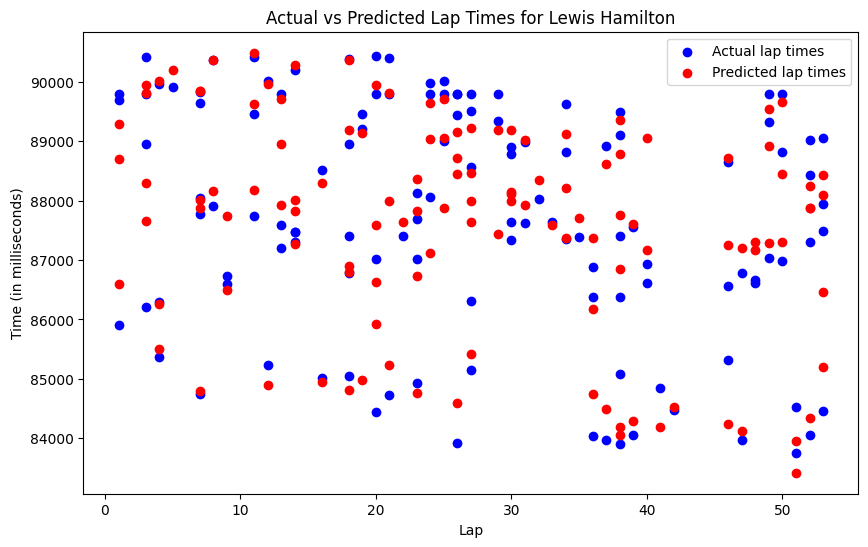

In [28]:
#Ábra létrehozása
plt.figure(figsize=(10,6))

#Tényleges köridők plotolása
plt.scatter(X_test['lap'], y_test, color='blue', label='Actual lap times')

#Prediktált köridők plotolása
plt.scatter(X_test['lap'], y_pred, color='red', label='Predicted lap times')

plt.title('Actual vs Predicted Lap Times for Lewis Hamilton')
plt.xlabel('Lap')
plt.ylabel('Time (in milliseconds)')
plt.legend()

plt.show()